In [1]:
import pandas as pd
df=pd.read_csv('train_set.csv')

In [2]:
df

,protein_id,class_id
0,8ugd_8:R:3U_model1,96
1,8h0v_18:R:c_model1,86
2,3j3q_1:DX:4F_model1,8
3,4u4u_23:XC:d1_model1,83
4,6rny_4:H:H_model1,34
...,...,...
9239,3j3y_1:HL:6R_model1,8
9240,4u4y_15:O:C3_model1,91
9241,7w31_26:AA:c_model1,18
9242,3j4k_1:E:E_model1,90


In [3]:
df['protein_id'] = df['protein_id'].str.replace(':', '_')



In [5]:
import os
from tqdm import tqdm

column_name = "protein_id"  #
vtk_folder = "./vtk/"

# Construire les noms de fichiers attendus
file_names = df[column_name].astype(str) + ".vtk"

# Liste des fichiers manquants
missing_files = []

for file_name in tqdm(file_names, desc="🔍 Vérification des fichiers"):
    file_path = os.path.join(vtk_folder, file_name)
    if not os.path.exists(file_path):
        missing_files.append(file_name)

# 📌 Résultats
if missing_files:
    print(f"\n🚨 {len(missing_files)} fichiers VTK manquants.")
    print("\n📌 Exemples de fichiers manquants :")
    print("\n".join(missing_files[:10]))  # 🔹 Affiche les 10 premiers fichiers manquants (évite d'afficher trop)
else:
    print("\n✅ Tous les fichiers existent.")

🔍 Vérification des fichiers: 100%|█████████████████████████████████████████████| 9244/9244 [00:00<00:00, 12251.59it/s]


✅ Tous les fichiers existent.


In [6]:
import pandas as pd

# Charger les données (à adapter selon ton contexte)
# df = pd.read_csv("ton_fichier.csv")

# Construire les noms de fichiers attendus
df["file_name"] = df["protein_id"].astype(str) + ".vtk"

# Trouver les fichiers en double
duplicates = df[df["file_name"].duplicated(keep=False)].copy()  # Garde tous les doublons

if duplicates.empty:
    print("\n✅ Aucun fichier en double trouvé.")
else:
    print(f"\n🚨 Il y a {duplicates['file_name'].nunique()} fichiers en double.")
    print("\n📌 Liste complète des doublons :")
    print(duplicates.sort_values("file_name").head(20))  # Affiche les 20 premiers

    # Vérifier si les fichiers dupliqués ont des `class_id` différents
    class_id_conflicts = duplicates.groupby("file_name")["class_id"].nunique()
    conflicting_files = class_id_conflicts[class_id_conflicts > 1]

    if not conflicting_files.empty:
        print(f"\n⚠️ {len(conflicting_files)} fichiers en double ont des `class_id` différents !")
        print("\n📌 Exemples de conflits :")
        print(duplicates[duplicates["file_name"].isin(conflicting_files.index)].sort_values("file_name").head(20))
    else:
        print("\n✅ Tous les fichiers en double ont le même `class_id`.")



✅ Aucun fichier en double trouvé.


In [6]:
df_sans_doublons = df.drop_duplicates(subset=["file_name"], keep="first")  # Garde la 1ère occurrence
df_sans_doublons = df_sans_doublons.drop(columns=["file_name"])

# Sauvegarder dans un nouveau fichier CSV
nouveau_csv = "cleaned_data.csv"
df_sans_doublons.to_csv(nouveau_csv, index=False)

print(f"\n✅ Nouveau fichier CSV généré : {nouveau_csv}")


✅ Nouveau fichier CSV généré : cleaned_data.csv


In [8]:
import numpy as np
from scipy import linalg
from scipy.spatial import ConvexHull

def fit_sphere_2_points(array):
	"""Fit a sphere to a set of 2, 3, or at most 4 points in 3D space. Note that
	point configurations with 3 collinear or 4 coplanar points do not have
	well-defined solutions (i.e., they lie on spheres with inf radius).

	- X     : M-by-3 array of point coordinates, where M<=4.
	- R     : radius of the sphere. R=Inf when the sphere is undefined, as
				specified above.
	- C     : 1-by-3 vector specifying the centroid of the sphere.
				C=nan(1,3) when the sphere is undefined, as specified above.
	Matlab code author: Anton Semechko (a.semechko@gmail.com)
	Date: Dec.2014"""

	N = len(array)

	if N > 4:
		print('Input must a N-by-3 array of point coordinates, with N<=4')
		return

	# Empty set
	elif N == 0:
		R = np.nan
		C = np.full(3, np.nan)
		return R, C

	# A single point
	elif N == 1:
		R = 0.
		C = array[0]
		return R, C

	# Line segment
	elif N == 2:
		R = np.linalg.norm(array[1] - array[0]) / 2
		C = np.mean(array, axis=0)
		return R, C

	else: # 3 or 4 points
		# Remove duplicate vertices, if there are any
		uniq, index = np.unique(array, axis=0, return_index=True)
		array_nd = uniq[index.argsort()]
		if not np.array_equal(array, array_nd):
			print("found duplicate")
			print(array_nd)
			R, C = fit_sphere_2_points(array_nd)
			return R, C

		tol = 0.01 # collinearity/co-planarity threshold (in degrees)
		if N == 3:
			# Check for collinearity
			D12 = array[1] - array[0]
			D12 = D12 / np.linalg.norm(D12)
			D13 = array[2] - array[0]
			D13 = D13 / np.linalg.norm(D13)

			chk = np.clip( np.abs(np.dot(D12, D13)) , 0., 1.)
			if np.arccos(chk)/np.pi*180 < tol:
				R = np.inf
				C = np.full(3, np.nan)
				return R, C

			# Make plane formed by the points parallel with the xy-plane
			n = np.cross(D13,D12)
			n = n / np.linalg.norm(n)
			##print("n", n)
			r = np.cross(n, np.array([0, 0, 1]))
			r = np.arccos(n[2]) * r / np.linalg.norm(r) # Euler rotation vector
			##print("r", r)
			Rmat = linalg.expm(np.array([
				[0., -r[2], r[1]],
				[r[2], 0., -r[0]],
				[-r[1], r[0], 0.]
			]))
			##print("Rmat", Rmat)
			#Xr = np.transpose(Rmat*np.transpose(array))
			Xr = np.transpose( np.dot(Rmat, np.transpose(array)) )
			##print("Xr", Xr)

			# Circle centroid
			x = Xr[:,:2]
			A = 2 * (x[1:] - np.full(2, x[0]))
			b = np.sum( (np.square(x[1:]) - np.square( np.full(2, x[0]) )), axis=1 )
			C = np.transpose(ldivide(A, b))

			# Circle radius
			R = np.sqrt( np.sum(np.square(x[0] - C)) )

			# Rotate centroid back into the original frame of reference
			C = np.append(C, [np.mean(Xr[:,2])], axis=0)
			C = np.transpose( np.dot(np.transpose(Rmat), C) )
			return R, C

		# If we got to this point then we have 4 unique, though possibly co-linear
		# or co-planar points.
		else:
			# Check if the the points are co-linear
			D12 = array[1] - array[0]
			D12 = D12 / np.linalg.norm(D12)
			D13 = array[2] - array[0]
			D13 = D13 / np.linalg.norm(D13)
			D14 = array[3] - array[0]
			D14 = D14 / np.linalg.norm(D14)

			chk1 = np.clip( np.abs(np.dot(D12, D13)) , 0., 1.)
			chk2 = np.clip( np.abs(np.dot(D12, D14)) , 0., 1.)
			if np.arccos(chk1)/np.pi*180 < tol or np.arccos(chk2)/np.pi*180 < tol:
				R = np.inf
				C = np.full(3, np.nan)
				return R, C

			# Check if the the points are co-planar
			n1 = np.linalg.norm(np.cross(D12, D13))
			n2 = np.linalg.norm(np.cross(D12, D14))

			chk = np.clip( np.abs(np.dot(n1, n2)) , 0., 1.)
			if np.arccos(chk)/np.pi*180 < tol:
				R = np.inf
				C = np.full(3, np.nan)
				return R, C

			# Centroid of the sphere
			A = 2 * (array[1:] - np.full(len(array)-1, array[0]))
			b = np.sum( (np.square(array[1:]) - np.square( np.full(len(array)-1, array[0]) )), axis=1 )
			C = np.transpose(ldivide(A, b))

			# Radius of the sphere
			R = np.sqrt( np.sum(np.square(array[0] - C), axis=0) )

			return R, C

def permute_dims(array, dims):
	return np.transpose( np.expand_dims(array, axis=max(dims)), dims )

def ldivide(array, vector):
	return np.linalg.solve(array, vector)

def exact_min_bound_sphere_3D(array):
	"""
 Compute exact minimum bounding sphere of a 3D point cloud (or a
 triangular surface mesh) using Welzl's algorithm.
   - X     : M-by-3 list of point co-ordinates or a triangular surface
			 mesh specified as a TriRep object.
   - R     : radius of the sphere.
   - C     : 1-by-3 vector specifying the centroid of the sphere.
   - Xb    : subset of X, listing K-by-3 list of point coordinates from
			 which R and C were computed. See function titled
			 'FitSphere2Points' for more info.
 REREFERENCES:
 [1] Welzl, E. (1991), 'Smallest enclosing disks (balls and ellipsoids)',
	 Lecture Notes in Computer Science, Vol. 555, pp. 359-370
 Matlab code author: Anton Semechko (a.semechko@gmail.com)
 Date: Dec.2014"""

	# Get the convex hull of the point set
	hull = ConvexHull(array)
	hull_array = array[hull.vertices]
	hull_array = np.unique(hull_array, axis=0)
	##print(len(hull_array))

	# Randomly permute the point set
	hull_array = np.random.permutation(hull_array)

	if len(hull_array) <= 4:
		R, C = fit_sphere_2_points(hull_array)
		return R, C, hull_array

	elif len(hull_array) < 1000:
		try:
			R, C, _ = B_min_sphere(hull_array, [])

			# Coordiantes of the points used to compute parameters of the
			# minimum bounding sphere
			D = np.sum(np.square(hull_array - C), axis=1)
			idx = np.argsort(D - R**2)
			D = D[idx]
			Xb = hull_array[idx[:5]]
			D = D[:5]
			Xb = Xb[D < 1E-6]
			idx = np.argsort(Xb[:,0])
			Xb = Xb[idx]
			return R, C, Xb
		except:
			raise Exception
	else:
		M = len(hull_array)
		dM = min([M // 4, 300])
# unnecessary ?
#		res = M % dM
#		n = np.ceil(M/dM)
#		idx = dM * np.ones((1, n))
#		if res > 0:
#			idx[-1] = res
#
#		if res <= 0.25 * dM:
#			idx[n-2] = idx[n-2] + idx[n-1]
#			idx = idx[:-1]
#			n -= 1

		hull_array = np.array_split(hull_array, dM)
		Xb = np.empty([0, 3])
		for i in range(len(hull_array)):
			R, C, Xi = B_min_sphere(np.vstack([Xb, hull_array[i]]), [])

			# 40 points closest to the sphere
			D = np.abs(np.sqrt(np.sum((Xi - C)**2, axis=1)) - R)
			idx = np.argsort(D, axis=0)
			Xb = Xi[idx[:40]]

		D = np.sort(D, axis=0)[:4]
		##print(Xb)
		##print(D)
		##print(np.where(D/R < 1e-3)[0])
		Xb = np.take(Xb, np.where(D/R < 1e-3)[0], axis=0)
		Xb = np.sort(Xb, axis=0)
		##print(Xb)

		return R, C, Xb


def B_min_sphere(P, B):
	eps = 1E-6
	if len(B) == 4 or len(P) == 0:
		R, C = fit_sphere_2_points(B) # fit sphere to boundary points
		return R, C, P

	# Remove the last (i.e., end) point, p, from the list
	P_new = P[:-1].copy()
	p = P[-1].copy()

	# Check if p is on or inside the bounding sphere. If not, it must be
	# part of the new boundary.
	R, C, P_new = B_min_sphere(P_new, B)
	if np.isnan(R) or np.isinf(R) or R < eps:
		chk = True
	else:
		chk = np.linalg.norm(p - C) > (R + eps)

	if chk:
		if len(B) == 0:
			B = np.array([p])
		else:
			B = np.array(np.insert(B, 0, p, axis=0))
		R, C, _ = B_min_sphere(P_new, B)
		P = np.insert(P_new.copy(), 0, p, axis=0)
	return R, C, P

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

def custom_train_test_split(points, labels, test_size=0.2, random_state=42):
    train_points, test_points, train_labels, test_labels = train_test_split(
        points, labels, test_size=test_size, random_state=random_state, stratify=labels
    )

    unique_classes = np.unique(labels)
    class_counts_in_test = {cls: np.sum(test_labels == cls) for cls in unique_classes}
    missing_classes = [cls for cls in unique_classes if class_counts_in_test[cls] == 0]

    for cls in missing_classes:
        class_indices = np.where(train_labels == cls)[0]
        if len(class_indices) == 0:
            continue  # 训练集中也没有这个类别，无法补充

        # 选择该类别的一个样本
        idx_to_move = class_indices[0]
        new_point, new_label = train_points[idx_to_move], train_labels[idx_to_move]

        # 添加到测试集
        test_points = np.concatenate([test_points, new_point[np.newaxis, :, :]], axis=0)
        test_labels = np.hstack([test_labels, new_label])

        # 从训练集中删除这个样本
        train_points = np.delete(train_points, idx_to_move, axis=0)
        train_labels = np.delete(train_labels, idx_to_move, axis=0)

    return train_points, test_points, train_labels, test_labels


In [12]:
import os
import pyvista as pv
import trimesh
import numpy as np
import pandas as pd
from tqdm import tqdm

# ======== 参数设定 ========

vtk_folder = "./vtk/"
output_folder = "./off_output/"
train_folder = os.path.join(output_folder, "train")
test_folder = os.path.join(output_folder, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)




# ======== 读取标签文件 ========

protein_ids = df["protein_id"].values
labels = df["class_id"].values

all_points = []
all_ids = []
all_labels = []

# ======== 处理每个 VTK 文件 ========
for pid, label in tqdm(zip(protein_ids, labels), total=len(labels), desc="🔄 预处理 VTK"):
    vtk_path = os.path.join(vtk_folder, pid + ".vtk")
    if not os.path.exists(vtk_path):
        print(f"⚠️ 跳过缺失文件: {pid}.vtk")
        continue
    try:
        mesh = pv.read(vtk_path)
        vertices = mesh.points
        faces = mesh.faces.reshape(-1, 4)[:, 1:]
        tri_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        sampled_points = tri_mesh.sample(2048)
        sampled_points = np.array(sampled_points, dtype=np.float32)

        R, C, _ = exact_min_bound_sphere_3D(sampled_points)
        sampled_points = (sampled_points - C) / R

        all_points.append(sampled_points)
        all_ids.append(pid)
        all_labels.append(label)
    except Exception as e:
        print(f"❌ 错误处理 {pid}: {e}")



🔄 预处理 VTK: 100%|███████████████████████████████████████████████████████████████| 9244/9244 [37:32<00:00,  4.10it/s]


In [14]:
all_points = np.array(all_points)
all_ids = np.array(all_ids)
all_labels = np.array(all_labels)

# ======== 划分训练/测试 ========
train_pts, test_pts, train_lbls, test_lbls = custom_train_test_split(all_points,all_labels)

# 和点的顺序同步划分 id
train_ids = all_ids[:len(train_pts)]
test_ids = all_ids[len(train_pts):]

# ======== 保存函数 ========
def save_off_and_labels(points_list, ids_list, labels_list, save_folder, csv_path):
    os.makedirs(save_folder, exist_ok=True)
    rows = []
    for pts, pid, label in zip(points_list, ids_list, labels_list):
        off_file = os.path.join(save_folder, pid + ".off")
        with open(off_file, "w") as f:
            f.write("OFF\n")
            f.write(f"{len(pts)} 0 0\n")
            for p in pts:
                f.write(f"{p[0]} {p[1]} {p[2]}\n")
        rows.append({"protein_id": pid, "label": label})
    pd.DataFrame(rows).to_csv(csv_path, index=False)

# ======== 保存文件和标签 ========
save_off_and_labels(train_pts, train_ids, train_lbls, train_folder, "train_labels.csv")
save_off_and_labels(test_pts, test_ids, test_lbls, test_folder, "test_labels.csv")

print("✅ 成功完成划分和保存（使用 custom_train_test_split）！")


✅ 成功完成划分和保存（使用 custom_train_test_split）！


9244 fichiers VTK trouvés.


🔄 Conversion en OFF:   0%|                                                                   | 0/9244 [00:00<?, ?it/s]

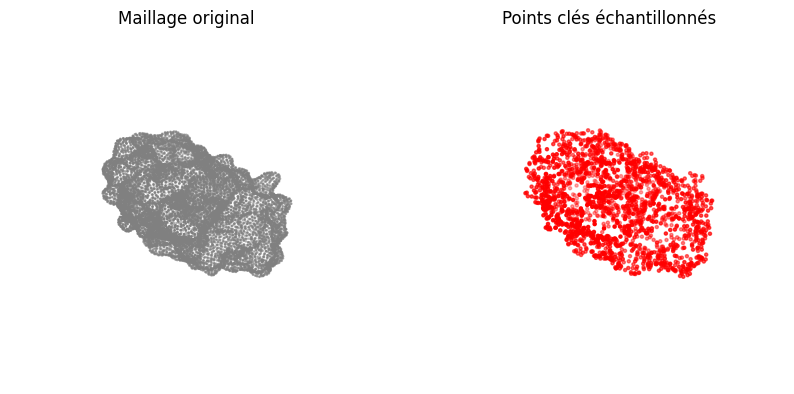

🔄 Conversion en OFF: 100%|████████████████████████████████████████████████████████| 9244/9244 [32:14<00:00,  4.78it/s]

🎉 Tous les fichiers VTK ont été traités avec succès !


In [9]:
import os
import pyvista as pv
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Définir les chemins des dossiers
dossier_vtk = "./train_set_vtk.tar/train_set_vtk/"  # Dossier contenant les fichiers VTK
dossier_off = "./off_output/"  # Dossier pour enregistrer les fichiers OFF

# Vérifier que le dossier de sortie existe
os.makedirs(dossier_off, exist_ok=True)

# Récupérer tous les fichiers VTK du dossier
fichiers_vtk = [f for f in os.listdir(dossier_vtk) if f.endswith(".vtk")]

if not fichiers_vtk:
    print("Aucun fichier VTK trouvé !")
else:
    print(f"{len(fichiers_vtk)} fichiers VTK trouvés.")

# Traiter chaque fichier VTK
for fichier_vtk in tqdm(fichiers_vtk, desc="🔄 Conversion en OFF"):
    chemin_vtk = os.path.join(dossier_vtk, fichier_vtk)
    chemin_off = os.path.join(dossier_off, fichier_vtk.replace(".vtk", ".off"))

    try:
        # Lire le fichier VTK
        mesh = pv.read(chemin_vtk)

        # Extraire les sommets et faces
        sommets = mesh.points  # Coordonnées des sommets
        faces = mesh.faces.reshape(-1, 4)[:, 1:]  # Supprimer le préfixe du nombre de sommets

        # Créer un maillage avec Trimesh
        maillage_trimesh = trimesh.Trimesh(vertices=sommets, faces=faces)

        # Échantillonner 2048 points clés
        points = maillage_trimesh.sample(2048)
        points = np.array(points, dtype=np.float32)
        R, C, Xb = exact_min_bound_sphere_3D(points)
        points = (points-C)/R

        # Sauvegarder uniquement les points échantillonnés au format OFF
        with open(chemin_off, "w") as f:
            f.write("OFF\n")
            f.write(f"{len(points)} 0 0\n")  # Nombre de sommets, pas de faces
            for p in points:
                f.write(f"{p[0]} {p[1]} {p[2]}\n")

        # Visualiser uniquement le 1er fichier traité
        if fichier_vtk == fichiers_vtk[0]:
            fig = plt.figure(figsize=(10, 5))

            # Maillage original
            ax1 = fig.add_subplot(121, projection="3d")
            ax1.scatter(sommets[:, 0], sommets[:, 1], sommets[:, 2], s=1, color="gray")
            ax1.set_title("Maillage original")
            ax1.set_axis_off()

            # Points clés échantillonnés
            ax2 = fig.add_subplot(122, projection="3d")
            ax2.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, color="red")
            ax2.set_title("Points clés échantillonnés")
            ax2.set_axis_off()

            plt.show()
    except Exception as e:
        print(f"❌ Échec du traitement pour {fichier_vtk} : {e}")

print("🎉 Tous les fichiers VTK ont été traités avec succès !")
